# Analysis of the samples from parallel runs: 

In [1]:
using IntervalSets
using Distributions
using Random, LinearAlgebra, Statistics, Distributions, StatsBase, ArraysOfArrays
using JLD2
using ValueShapes
using TypedTables
using Measurements
using TypedTables
using HypothesisTests
using HDF5
using CSV

In [2]:
# using PyPlot
using Plots
pyplot()

Plots.PyPlotBackend()

In [3]:
using PyPlot

In [4]:
using Revise
using BAT

## Functions: 

In [5]:
function convert_to_typed_table(table)
    density_integral = [Measurements.measurement(parse.(Float64, split(v_run, " ± "))...) for v_run in table.density_integral]
    integration_cpu_time = collect(table.integration_cpu_time)
    sampling_cpu_time = collect(table.sampling_cpu_time)
    n_threads = collect(table.n_threads)
    worker_id = collect(table.worker_id)
    sum_weights = collect(table.sum_weights)
    samples_ind = [UnitRange(parse.(Int64, split(v_run, ":"))...) for v_run in table.samples_ind ]
    sampling_wc = [UnitRange(parse.(Int64, split(v_run, ":"))...) for v_run in table.sampling_wc ]
    integration_wc = [UnitRange(parse.(Int64, split(v_run, ":"))...) for v_run in table.integration_wc ]
    
    TypedTables.Table(
        density_integral=density_integral,
        integration_cpu_time=integration_cpu_time,
        sampling_cpu_time=sampling_cpu_time,
        n_threads=n_threads,
        worker_id=worker_id,
        sum_weights=sum_weights,
        samples_ind=samples_ind,
        sampling_wc=sampling_wc,
        integration_wc=integration_wc
    )
end

convert_to_typed_table (generic function with 1 method)

In [6]:
function plot_separated_timeline(data::T;figsize=(8,8)) where {T<:Table}
    
    minimum_timestamp = minimum([ts[1] for ts in data.sampling_wc])
    
    timestamps_shifted = [([
                data.sampling_wc[ts][1], data.sampling_wc[ts][end], 
                data.integration_wc[ts][1], data.integration_wc[ts][end]
                ] .- minimum_timestamp) .* 10^-9 for ts in 1:length(data.sampling_wc)]
    
    maximum_timestamp  = maximum(maximum.(timestamps_shifted))
    maximum_cpu_time = maximum([data.sampling_cpu_time..., data.integration_cpu_time...])
    
    proc_ids = collect(minimum(data.worker_id):maximum(data.worker_id))
    n_workers = length(proc_ids)
    
    x_min = 0
    x_max = maximum_timestamp
    y_min = 0
    y_max_tmp = Float64[]
    
    label_1 = "Sampling"
    label_2 = "Integration"
    
    @show n_workers, maximum(proc_ids)
    fig, ax = plt.subplots(n_workers,1, sharex=true, figsize=figsize)
    fig.subplots_adjust(hspace=0.0, wspace=0.00)
  
    for (i,j) in enumerate(timestamps_shifted)

        r1 = matplotlib.patches.Rectangle([j[1], 0.0], j[2]-j[1], data.sampling_cpu_time[i]/(j[2]-j[1]), fill=true, 
            linewidth=0.8, color="royalblue", alpha=0.5, label=label_1) 
        ax[data.worker_id[i] - 1].add_patch(r1)
        r2 = matplotlib.patches.Rectangle([j[3], 0.0], j[4]-j[3], data.integration_cpu_time[i]/(j[4]-j[3]), 
            fill=true, linewidth=0.8, color="peru", alpha=0.5, label=label_2) 
        ax[data.worker_id[i] - 1].add_patch(r2)

        push!(y_max_tmp, data.sampling_cpu_time[i]/(j[2]-j[1]))
        push!(y_max_tmp, data.integration_cpu_time[i]/(j[4]-j[3]))

        label_1 = "_nolegend_"
        label_2 = "_nolegend_"

    end

     ax[1].legend(loc="upper left", frameon=false, framealpha=0.8, ncol=1, bbox_to_anchor=(1.02, 1.0),)

    for i in 1:n_workers
        ax[i].set_xlim(x_min, x_max);
        ax[i].set_ylim(0, ceil(maximum(y_max_tmp)));
        ax[i].set_ylabel("w$i", labelpad=10,  size=10)

    #     ax[i].set_yticks(range(0, stop=floor(maximum(y_max_tmp)), step=1), minor=false)
        ax[i].grid(axis="y", which="both", alpha=0.2, )

        if i<n_workers
            ax[i].get_xaxis().set_visible(false) 
        end
    end

    fig.text(0.06, 0.5, "CPU time / Wall-clock time", va="center", rotation="vertical", size=12, weight="bold")
    ax[n_workers].set_xlabel("Wall-clock time [s]", labelpad=12,  size=12, weight="bold")
    
end

plot_separated_timeline (generic function with 1 method)

In [83]:
prior = NamedTupleDist(a = [Uniform(-100,100) for i in 1:9]);

function get_cpu_time(name)
    csvfile = CSV.File(name)
    tt = Table(csvfile)
    table = convert_to_typed_table(tt)
    sum(table.integration_cpu_time)+sum(table.sampling_cpu_time)
end

function get_wc_time(name)
    csvfile = CSV.File(name)
    tt = Table(csvfile)
    table = convert_to_typed_table(tt)
    return (maximum([t[end] for t in table.integration_wc]) - minimum([t[1] for t in table.sampling_wc]))* 10^-9
end

function get_integrals(name)
    csvfile = CSV.File(name)
    tt = Table(csvfile)
    table = convert_to_typed_table(tt)
    return exp(log(sum(table.density_integral)) + 47.684856298932324)
end

function get_nsamples(name)
    csvfile = CSV.File(name)
    tt = Table(csvfile)
    table = convert_to_typed_table(tt)
    return table.samples_ind[end][end]
end

get_nsamples (generic function with 1 method)

# Analysis: 

In [84]:
names_1 = ["table1-1.csv", "table1-2.csv", "table1-3.csv", "table1-4.csv"]
names_2 = ["table2-1.csv", "table2-2.csv", "table2-3.csv", "table2-4.csv"]
names_3 = ["table3-1.csv", "table3-2.csv", "table3-3.csv", "table3-4.csv", "table3-5.csv", "table3-6.csv", "table3-7.csv"]
names_4 = ["table4-1.csv", "table4-2.csv", "table4-3.csv", "table4-4.csv", "table4-5.csv", "table4-6.csv", "table4-7.csv"]
names_5 = ["table5-1.csv", "table5-2.csv", "table5-3.csv", "table5-4.csv", "table5-5.csv", "table5-6.csv", "table5-7.csv"]

path = "../data/Benchmark-1/"


"../data/Benchmark-1/"

In [85]:
run_1 = Table(
    ind = [1,2,3,4], 
    n_samples = [10^5, 5*10^4, 2*10^4, 10^4], 
    length_samples = [get_nsamples(t) for t in path.*names_1],
    n_subsets = [15,30,75,150],
    cpu_time = [get_cpu_time(t) for t in path .* names_1],
    wc_time = [get_wc_time(t) for t in path .* names_1],
    integral = [get_integrals(t).val for t in path .* names_1],
    integral_err = [get_integrals(t).err for t in path .* names_1],
    n_workers = [15 for t in path .* names_1],
    n_chains=[10, 10, 10, 10], 
)


run_2 = Table(
    ind = [1,2,3,4], 
    n_chains=[10, 10, 10, 10], 
    n_samples = [6*10^4, 3*10^4, 15*10^3, 10^4], 
    length_samples = [get_nsamples(t) for t in path.*names_2],
    n_subsets = [25,50,100,150],
    cpu_time = [get_cpu_time(t) for t in path .* names_2],
    wc_time = [get_wc_time(t) for t in path .* names_2],
    integral = [get_integrals(t).val for t in path .* names_2],
    integral_err = [get_integrals(t).err for t in path .* names_2],
    n_workers = [25 for t in path .* names_2]
)

run_3 = Table(
    ind = [1,2,3,4,5,6,7], 
    n_chains=[10, 10, 10, 10, 10, 10, 10], 
    n_samples = [3*10^5, 10^5, 6*10^4, 3*10^4, 2*10^4, 15*10^3, 10^4], 
    length_samples = [get_nsamples(t) for t in path.*names_3],
    n_subsets = [5, 15, 25, 50, 75, 100,150],
    cpu_time = [get_cpu_time(t) for t in path .* names_3],
    wc_time = [get_wc_time(t) for t in path .* names_3],
    integral = [get_integrals(t).val for t in path .* names_3],
    integral_err = [get_integrals(t).err for t in path .* names_3],
    n_workers = [5 for t in path .* names_3]
)

run_4 = Table(
    ind = [1,2,3,4,5,6,7], 
    n_chains=[10, 10, 10, 10, 10, 10, 10], 
    n_samples = [75*10^4, 375*10^3, 1875*102, 15*10^4, 5*10^4, 15*10^3, 10^4],
    length_samples = [get_nsamples(t) for t in path.*names_4],
    n_subsets = [2,4,8,10,30,100,150],
    cpu_time = [get_cpu_time(t) for t in path .* names_4],
    wc_time = [get_wc_time(t) for t in path .* names_4],
    integral = [get_integrals(t).val for t in path .* names_4],
    integral_err = [get_integrals(t).err for t in path .* names_4],
    n_workers = [2 for t in path .* names_4]
)

run_5 = Table(
    ind = [1,2,3,4,5,6,7], 
    n_chains=[10, 10, 10, 10, 10, 10, 10], 
    n_samples = [15*10^5, 75*10^4, 375*10^3, 1875*102, 15*10^4, 15*10^3, 10^4],
    length_samples = [get_nsamples(t) for t in path.*names_5],
    n_subsets = [1, 2, 4, 8, 10, 100, 150],
    cpu_time = [get_cpu_time(t) for t in path .* names_5],
    wc_time = [get_wc_time(t) for t in path .* names_5],
    integral = [get_integrals(t).val for t in path .* names_5],
    integral_err = [get_integrals(t).err for t in path .* names_5],
    n_workers = [1 for t in path .* names_5]
)

Table with 10 columns and 7 rows:
     ind  n_chains  n_samples  length_samples  n_subsets  cpu_time  wc_time  ⋯
   ┌──────────────────────────────────────────────────────────────────────────
 1 │ 1    10        1500000    13907849        1          24154.3   2535.79  ⋯
 2 │ 2    10        750000     14419784        2          10233.2   1163.15  ⋯
 3 │ 3    10        375000     14675516        4          8437.17   1014.02  ⋯
 4 │ 4    10        191250     14772202        8          8844.38   1108.59  ⋯
 5 │ 5    10        150000     14849758        10         7881.76   989.547  ⋯
 6 │ 6    10        15000      14618758        100        7017.89   1273.84  ⋯
 7 │ 7    10        10000      14670709        150        9711.65   1776.36  ⋯

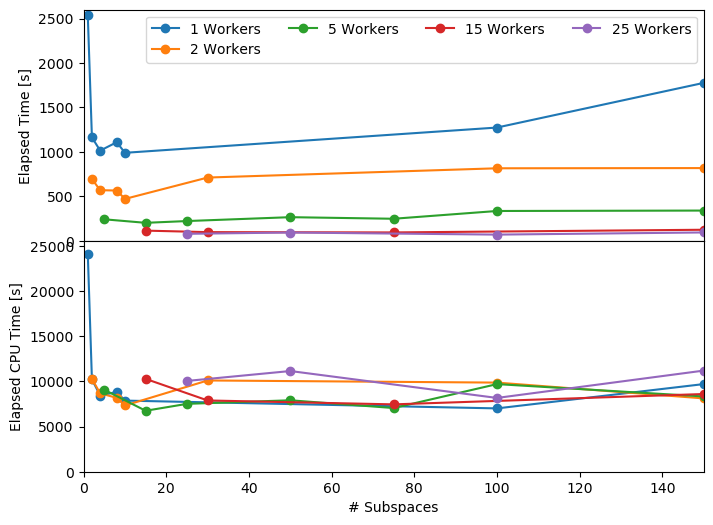

PyObject Text(24.000000000000014, 0.5, 'Elapsed CPU Time [s]')

In [122]:
fig, ax = plt.subplots(2,1, figsize=(8,6), sharex=true)

fig.subplots_adjust(hspace=0.00, wspace=0.03)

ax[1].plot(run_5.n_subsets, run_5.wc_time, "o-", color="C0", label="1 Workers")
ax[1].plot(run_4.n_subsets, run_4.wc_time, "o-", color="C1", label="2 Workers")
ax[1].plot(run_3.n_subsets, run_3.wc_time, "o-", color="C2", label="5 Workers")
ax[1].plot(run_1.n_subsets, run_1.wc_time, "o-", color="C3", label="15 Workers")
ax[1].plot(run_2.n_subsets, run_2.wc_time, "o-", color="C4", label="25 Workers")
ax[1].set_xlim(0,150)
ax[1].set_ylim(0,2600)

ax[1].set_ylabel("Elapsed Time [s]")
ax[1].legend(ncol=4)

ax[2].plot(run_5.n_subsets, run_5.cpu_time,  "o-", color="C0", label="1 Workers")
ax[2].plot(run_4.n_subsets, run_4.cpu_time,  "o-", color="C1", label="2 Workers")
ax[2].plot(run_3.n_subsets, run_3.cpu_time,  "o-", color="C2", label="5 Workers")
ax[2].plot(run_1.n_subsets, run_1.cpu_time,  "o-", color="C3", label="15 Workers")
ax[2].plot(run_2.n_subsets, run_2.cpu_time,  "o-", color="C4", label="25 Workers")
ax[2].set_xlim(0,150)
ax[2].set_ylim(0,25600)


ax[2].set_xlabel("# Subspaces")
ax[2].set_ylabel("Elapsed CPU Time [s]")

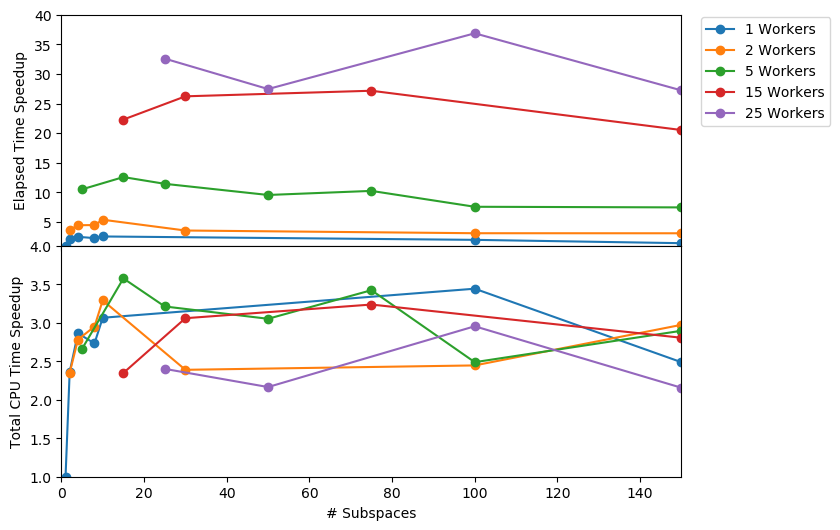

PyObject Text(24.000000000000014, 0.5, 'Total CPU Time Speedup')

In [129]:
r_1_1 = run_5.wc_time[1]
r_1_2 = run_5.cpu_time[1]

fig, ax = plt.subplots(2,1, figsize=(8,6), sharex=true)

fig.subplots_adjust(hspace=0.00, wspace=0.03)

ax[1].plot(run_5.n_subsets, r_1_1 ./ run_5.wc_time, "o-", color="C0", label="1 Workers")
ax[1].plot(run_4.n_subsets, r_1_1 ./ run_4.wc_time, "o-", color="C1", label="2 Workers")
ax[1].plot(run_3.n_subsets, r_1_1 ./ run_3.wc_time, "o-", color="C2", label="5 Workers")
ax[1].plot(run_1.n_subsets, r_1_1 ./ run_1.wc_time, "o-", color="C3", label="15 Workers")
ax[1].plot(run_2.n_subsets, r_1_1 ./ run_2.wc_time, "o-", color="C4", label="25 Workers")
ax[1].set_xlim(0,150)
ax[1].set_ylim(1,40)

ax[1].set_ylabel("Elapsed Time Speedup")
ax[1].legend(ncol=1, bbox_to_anchor=(1.02, 1.02))

ax[2].plot(run_5.n_subsets, r_1_2 ./ run_5.cpu_time,  "o-", color="C0", label="1 Workers")
ax[2].plot(run_4.n_subsets, r_1_2 ./ run_4.cpu_time,  "o-", color="C1", label="2 Workers")
ax[2].plot(run_3.n_subsets, r_1_2 ./ run_3.cpu_time,  "o-", color="C2", label="5 Workers")
ax[2].plot(run_1.n_subsets, r_1_2 ./ run_1.cpu_time,  "o-", color="C3", label="15 Workers")
ax[2].plot(run_2.n_subsets, r_1_2 ./ run_2.cpu_time,  "o-", color="C4", label="25 Workers")
ax[2].set_xlim(0,150)
ax[2].set_ylim(1,4)


ax[2].set_xlabel("# Subspaces")
ax[2].set_ylabel("Total CPU Time Speedup")

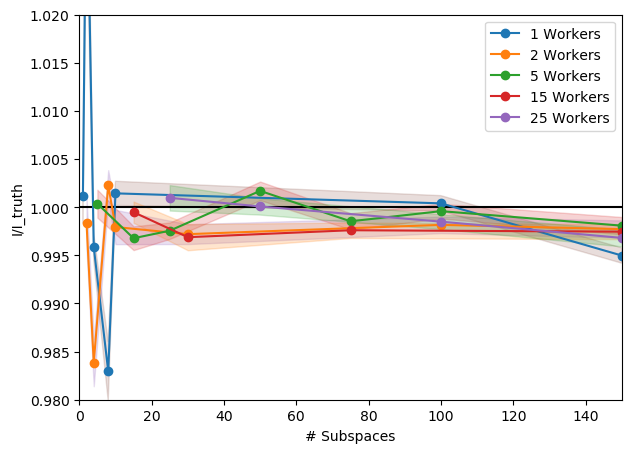

PyObject <matplotlib.legend.Legend object at 0x7fc8581f5610>

In [127]:
fig, ax = plt.subplots(1,1, figsize=(7,5))


ax.plot(run_5.n_subsets, run_5.integral, "o-", color="C0", label="1 Workers")
ax.fill_between(run_5.n_subsets,run_5.integral .- run_5.integral_err, run_5.integral .+ run_5.integral_err, alpha=0.2, color="C5", )

ax.plot(run_4.n_subsets, run_4.integral, "o-", color="C1", label="2 Workers")
ax.fill_between(run_4.n_subsets,run_4.integral .- run_4.integral_err, run_4.integral .+ run_4.integral_err, alpha=0.2, color="C4", )

ax.plot(run_3.n_subsets, run_3.integral, "o-", color="C2", label="5 Workers")
ax.fill_between(run_3.n_subsets,run_3.integral .- run_3.integral_err, run_3.integral .+ run_3.integral_err, alpha=0.2, color="C3", )

ax.plot(run_1.n_subsets, run_1.integral, "o-", color="C3", label="15 Workers")
ax.fill_between(run_1.n_subsets,run_1.integral .- run_1.integral_err, run_1.integral .+ run_1.integral_err, alpha=0.2, color="C1", )

ax.plot(run_2.n_subsets, run_2.integral, "o-", color="C4",  label="25 Workers")
ax.fill_between(run_2.n_subsets,run_2.integral .- run_2.integral_err, run_2.integral .+ run_2.integral_err, alpha=0.2, color="C2", )

ax.hlines([1], 0, 150)

ax.set_xlim(0,150)
ax.set_ylim(0.98,1.02)

ax.set_xlabel("# Subspaces")
ax.set_ylabel("I/I_truth")

ax.legend()

# Run overview: 

### Load Samples: 

In [ ]:
outp_tmp = bat_read(path .* names_2[4])
samples = varshape(prior).(outp_tmp);

In [ ]:
# plot(samples, vsel=[1,2,3,4,5], size=(1100,700), globalmode=true, localmode=true, 
#     upper=Dict("mean"=>false, "globalmode"=>false, "localmode"=>false,),
# )

### Run Info:

In [71]:
csvfile = CSV.File(path .* names_1[4])
tt = Table(csvfile)
table = convert_to_typed_table(tt);

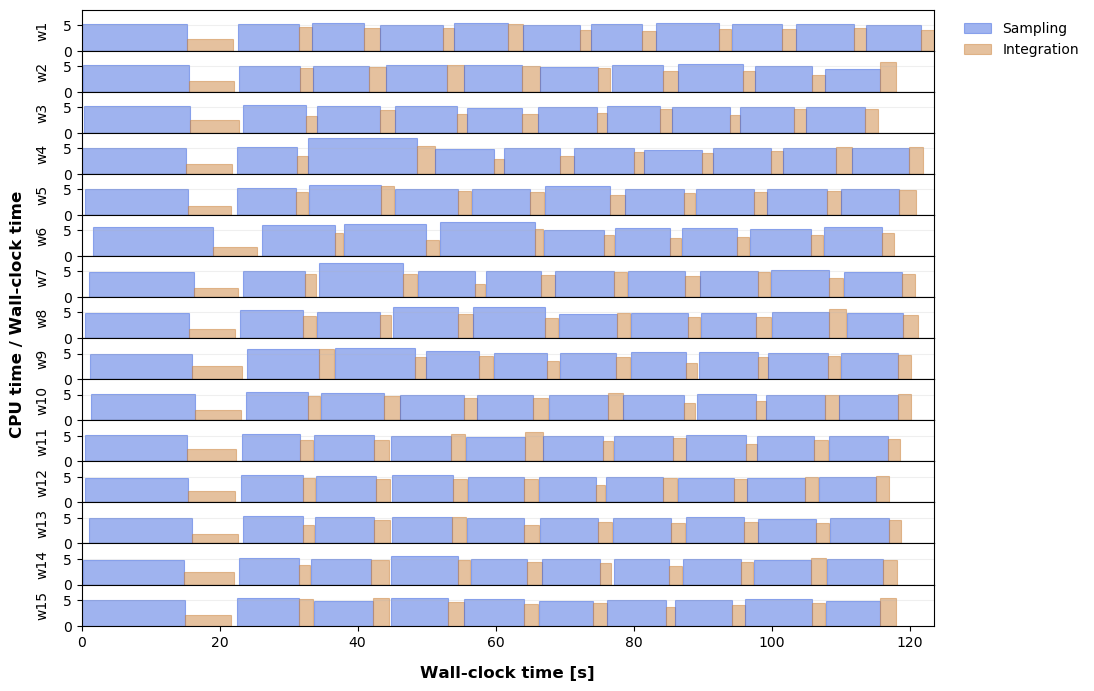

(n_workers, maximum(proc_ids)) = (15, 16)


PyObject Text(0.5, 25.00000000000001, 'Wall-clock time [s]')

In [72]:
plot_separated_timeline(table, figsize=(11,8))